# Tool calling Agent

## Architecture

![Screenshot 2025-11-13 160126.png](<attachment:Screenshot 2025-11-13 160126.png>)

## Provide me recent AI News?

for the above question LLM can't able to answer the query, because the LLM knowledge is outdated (may it's trained on oe year back data). so in this case we need to a call ==tool== to provide the response. The external may be predefined or custom tools (add, sub, mul, div etc).

The flow is basically, it will start -> llm chatbot -> tool calling - end


## How does LLM know, which tool should call ?

1. Inside the chatbot we will use **LLM**.
2. **LLM** is actually the brain behind taking this decision. but how?
3. Because the **LLM** is binded with the tools **(LLM + binded tools)**, What does it mean?
4. Let's say i have created a custom function, The function is a added as a tool to the LLM. It cab be binded with LLM itself.
5. **Then the LLM, here whenever you define any custom tool, you also need to provide the doc string to the function**
6. **with help of doc string, LLM can able to understand. if this inputs and arguments matches with the chatbot**
7. The LLM will call the particular tool
 
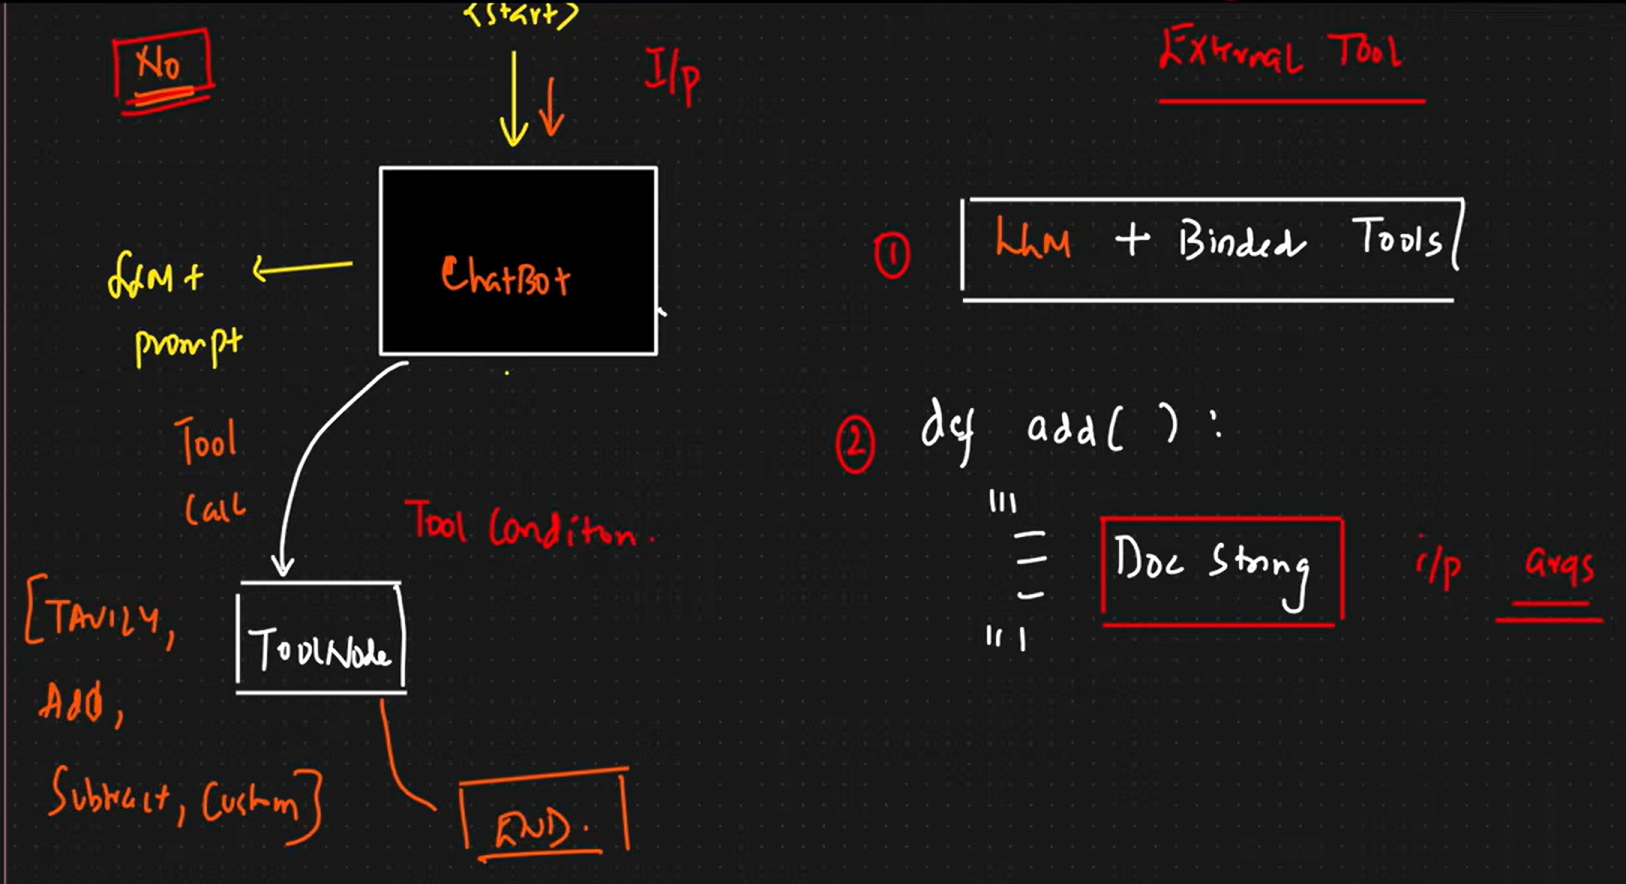

In [ ]:
# Start --> tool_calling_llm --> tools ----> END

## Chatbot with Tools

In [ ]:
# install the below libraries

# langchain_tavily, 

## 1. Import libraries

In [ ]:
import os
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain .chat_models import init_chat_model # 2nd approach to use llm models

load_dotenv()

## 2. initialize the LLM

In [ ]:
# LLM initialization
llm = ChatGroq(model='llama-3.1-8b-instant')
llm

In [ ]:
# %pip install langchain_tavily

## 3. define predefined tool

In [ ]:
# Define tavily search tool (it's just internet search tool)
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=2)
# test this tool
tavily_tool.invoke("tell me about the AI?")

## 4. define a custom tool

In [ ]:
# Doc string is very important for LLM to understand the custom function
def multiply(a:int, b:int) -> int:
    
    """ Multiply a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a * b

## 5. combine the tools

In [ ]:
tools = [tavily_tool, multiply]

## 6. bind the llms with tools

In [ ]:
# bind llm and tools
llm_with_tools = llm.bind_tools(tools)
print(llm_with_tools)

## 7. Define a State

In [ ]:
# define a state

class State(TypedDict):
    # messages have the type 'list'. The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in the case, it appends messages to the list, rather than overwriting them)
    # Annotated 
    messages: Annotated[list, add_messages]


# # build a graph builder
# graph_builder = StateGraph(State)
# graph_builder

## 7. Define a Graph

In [ ]:
# Define a StateGraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node definition
def tool_calling_llm(state: State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}


# Graph
builder = StateGraph(State)

# add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

# add conditional edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    'tool_calling_llm',
    # the below condition works as below
    # if the latest message (result) from assistant is a tool call -> tool_condition routes to tool
    # if the latest message (result) from assistant is *not a tool* -> tool_condition routes to END
    tools_condition 
)
builder.add_edge('tools', END) # if it is a tool call, after the tool call it will end

# by default if it is a llm call it will end automatically


# compile the graph
graph = builder.compile()

In [ ]:
graph

### test case -1 (predefined tool call)

In [ ]:
# call the graph
response = graph.invoke({"messages": "What is the recent AI news?"})

In [ ]:
response

In [ ]:
response['messages'][-1].content

In [ ]:
for m in response['messages']:
    print(m.pretty_print())

### test case -2 (custom tool call)

In [ ]:
response1 = graph.invoke({'messages': 'what is 2 multiplied by 3'})
for m in response1['messages']:
    print(m.pretty_print())

### test case - 3 (custom tool)

In [ ]:
response2 = graph.invoke({'messages': 'what is 5 multiplied by 2 and then multiply 10'})
for m in response2['messages']:
    print(m.pretty_print())

### test case - 4 (test with predefined and custom tools)

In [ ]:
response3 = graph.invoke({'messages': 'Give me the recent ai news and then mutiply 5 by 10 then multiply by 2'})
for m in response3['messages']:
    print(m.pretty_print())

1. Sometimes there might be chance of end operation post the tool call. Ex: give me the recent ai news --> the chatbot call the tool --> provide response -- end

2. Then what about 5 by 10 multiplication

3. Then multiply by 2?

4. The answer is once the tool call is completed, we need to send tool response back to the LLM. Here LLM is the decision maker.

5. This is called ReAct Agent



## What is a ReAct Agent?

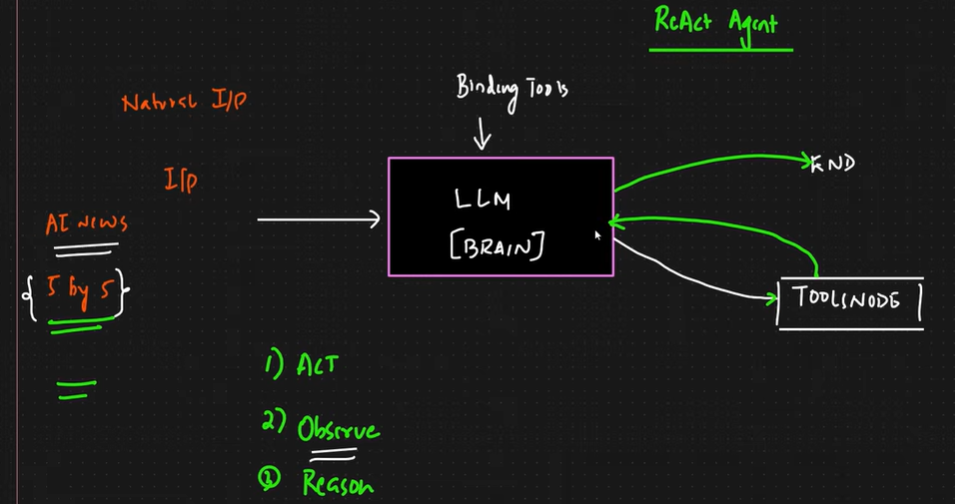

## ReAct Architecture

1. LLM is a brain

2. it is binded with tools

3. Now llm can takes the input and split the input

4. first split it will send to the tool and get the response... instead of ending the process it will send the response back to the LLM.

5. LLM sends the second question to the tool and send beck to the llm

6. Now llm summarize the responses and provide you the final response. This process is called ReAct architecture

7. In ReAct 3 main key terms are there
        a. ACT  - whenever input comes, LLM makes a tool call 
        b. Observe -  When the output of the tool comes, The LLM will observe and will it end or again need to call the tool (repetative process)
        c. Reason - What the LLM should do that LLM is making a decision

--- solution in next note book ---